# Modeling the Reddit Data

The Subreddits include:
- bodyweight fitness = 0
- powerlifting = 1 

### Import Libraries

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Boosting
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.datasets import make_classification  # creates random datasets

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Import Modeling Data

In [117]:
df = pd.read_csv('../datasets/model_ready_data_tvec.csv')

## Baseline Model

In [185]:
# baseline accuracy - the percentage of the majority class
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

**The baseline model is 0.5. This is the model to beat**

## Model 1: Decision Tree

In [119]:
# Creat X and y variables
X = df.drop('subreddit', axis=1) 
y = df['subreddit']

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Instantiate the model
dt = DecisionTreeClassifier()

# Fit model.
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [120]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 0.9958571428571429
Score on testing set: 0.8681666666666666


**Analysis:**
<br>
The training score is .996 and the testing score is .868, which indicates that the model is overfit. This is an expected weekness a decision tree with untuned parameters. In the code below I will perform a grid search to find better parameters. 

**Grid search to fine tune the parameters**

In [121]:
params = {
    'max_depth': [2, 3, 5],
          'min_samples_split': [5, 10, 15],
          'min_samples_leaf': [2, 3, 4],
    'ccp_alpha': [0.001, 0.01, 0.1,]      
}

grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42),
                    param_grid = params,
                    cv = 3,
                    verbose = 1)

In [122]:
# GridSearch over the above parameters on the training data.
grid.fit(X_train, y_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  5.7min finished


346.5070788860321


In [123]:
# Finds the best decision tree
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=5, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

In [124]:
# What was the cross-validated score of the above decision tree?
grid.best_score_

0.697428736720263

In [125]:
# Evaluate model.
print(f'Score on training set: {grid.score(X_train, y_train)}')
print(f'Score on testing set: {grid.score(X_test, y_test)}')

Score on training set: 0.7021428571428572
Score on testing set: 0.696


**Analysis:**
<br>
Grid search chose the folowing values for the parameters:
- ccp_alpha = 0.001
- max_depth = 5
- min_samples_lef = 2
- min_samples_split = 5
<br>
The cross validated score was 0.697.
<br>
The training score was 0.702 and the testing score was 0.696. These are drops from the original decision tree scores, which signals that the model is getting worse in its predictive ability. However, as the model gets more general the high variance error should also be reduced. 

### Confusion Matrix Analysis

In [126]:
# Generate predictions on test set.
y_pred_dt = grid.predict(X_test)

In [127]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test,
                                  y_pred_dt).ravel()

print(confusion_matrix(y_test,
                       y_pred_dt))

[[2968   49]
 [1775 1208]]


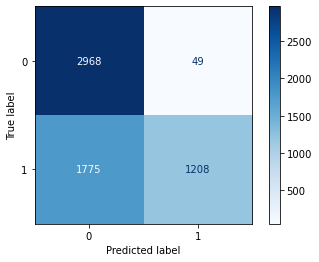

In [128]:
# Plot confusion matrix
plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', values_format='d');
# code --> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

In [173]:
tp_dt = 1208 # True Positives (Decision Tree)
tn_dt = 2968 # True Negatives (Decision Tree)
fp_dt = 49 # False Positives (Decision Tree)
fn_dt = 1775 # False Negatives (Decision Tree)

# code reference --> https://towardsdatascience.com/build-and-compare-3-models-nlp-sentiment-prediction-67320979de61

In [178]:
# Calculate sensitivity.

sens_dt = tp_dt / (tp_dt + fn_dt)

print(f'Sensitivity: {round(sens_dt, 4)}')

Sensitivity: 0.405


In [179]:
# Calculate specificity.

spec_dt = tn_dt / (tn_dt + fp_dt)

print(f'Specificity: {round(spec_dt, 4)}')

Specificity: 0.9838


In [180]:
# Calculate accuracy.

accuracy_dt = (tp_dt + tn_dt) / (tp_dt + tn_dt + fp_dt + fn_dt) 

print(f'Accuracy: {round(accuracy_dt, 4)}')

Accuracy: 0.696


In [181]:
# Calculate precision.

precision_dt = tp_dt / (tp_dt + fp_dt)

print(f'Precision: {round(precision_dt, 4)}')

Precision: 0.961


In [182]:
# Calculate recall.

recall_dt = tp_dt / (tp_dt + fn_dt)

print(f'Recall: {round(recall_dt, 4)}')

Recall: 0.405


**Analysis:**
<br>
The decision tree model has a sensitivity of 40.5%, which means it correctly predicts a powerlifting subreddit post only about 40% of the time or more noteably __incorrectly__ predicts it about 60% of the time. The specificity is much better at 98%. The model creates very few false positives.

## Model 2: Random Forests and ExtraTrees

**_Random forests us a modified tree learning algorithm that selects, at each split in the learning process, a random subset of the features. This counters the correlation between base trees that would otherwise choose the few features that are strong predictors of the target variable._**

In [136]:
# Instantiate the Random Forest model
rf = RandomForestClassifier(n_estimators=100)

In [137]:
# Instantiate the Extra Trees model
et = ExtraTreesClassifier(n_estimators=100)

In [138]:
# Find the cross_val score for the Random Forest model
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9009285714285713

In [139]:
# Find the cross_val score for the Extra Tree model
cross_val_score(et, X_train, y_train, cv=5).mean()

0.8972857142857142

**Both the Random Forest and ExtraTrees models have cross val scores of about 0.90. Since the Random Forest model is slightly better I'll use it in the grid search to find ideal parameters.**

In [140]:
# Grid Search

rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [None, 1, 2, 3],
}

gs = GridSearchCV(rf, param_grid=rf_params, cv=3)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)


0.9006426979543711
218.96147513389587


In [141]:
# Training set score
gs.score(X_train, y_train)

0.9958571428571429

In [142]:
# Testing set score
gs.score(X_test, y_test)

0.9018333333333334

**Analysis:**
<br>
The best grid score was 0.912. 
<br>
The best parameters are as follows:
- base_estimator_max_depth = 2
- learning_rate = 1.0
- n_estimators = 100
<br>
The grid search score on the training set was 0.996 and on the testing set was 0.902. The high testing score indicates that this model is also overfit; however, the different between the training and testing scores is shrinking. 

In [146]:
# Generate predictions on test set.
y_pred_rf = rf.predict(X_test)

In [147]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test,
                                  y_pred_rf).ravel()

print(confusion_matrix(y_test,
                       y_pred_rf))

[[2809  208]
 [ 362 2621]]


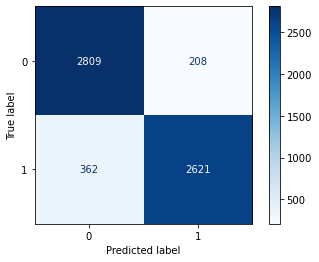

In [148]:
# Plot confusion matrix
plot_confusion_matrix(rf, X_test, y_test, cmap='Blues', values_format='d');

In [188]:
tp_rf = 2621 # True Positives (Random Forest)
tn_rf = 2809 # True Negatives (Random Forest)
fp_rf = 208 # False Positives (Random Forest)
fn_rf = 362 # False Negatives (Random Forest)

In [189]:
# Calculate sensitivity.

sens_rf = tp_rf / (tp_rf + fn_rf)

print(f'Sensitivity: {round(sens_rf, 4)}')

Sensitivity: 0.8786


In [190]:
# Calculate specificity.

spec_rf = tn_rf / (tn_rf + fp_rf)

print(f'Specificity: {round(spec_rf, 4)}')

Specificity: 0.9311


In [191]:
# Calculate accuracy.

accuracy_rf = (tp_rf + tn_rf) / (tp_rf + tn_rf + fp_rf + fn_rf) 

print(f'Accuracy: {round(accuracy_rf, 4)}')

Accuracy: 0.905


In [192]:
# Calculate precision.

precision_rf = tp_rf / (tp_rf + fp_rf)

print(f'Precision: {round(precision_rf, 4)}')

Precision: 0.9265


In [193]:
# Calculate recall.

recall_rf = tp_rf / (tp_rf + fn_rf)

print(f'Recall: {round(recall_rf, 4)}')

Recall: 0.8786


**Analysis:**
<br>
The random forest model has a sensitivity of 87.9%, which is significantly better than the first model. The specificity is 93%, which is about the same as the first model. The model also suffers from being overfit.

### Boosting as an Ensemble Model

**_Boosting a model has several benefits: the model achieves higher performance than bagging when the hyperparameters are properly tuned, it works equally well for classification and regression, and it is resilient to outliers.<br>The disadvantages are that the hyperparameters are time consuming to properly tune, they don't scale with large amounts of data, and there is a higher risk of overfitting.<br>The aim of boosting is to reduce bias. The theory is that many weak learners can combine to make a single strong learner. Boosting uses shallow bias-base estimators so each weak learner has low variance and high bias.<br>AdaBoost works by fitting a sequence of weak learners on repeatedly modified versions of the data. The more the model misclassifies objects, the objects become more likely to be sampled in the subsequent trees.<br>Gradient boosting learns from its errors. It fits subsequent trees to the residuals of the last tree._**

In [156]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# code --> by Riley Dallas from Austin

ada = AdaBoostClassifier(base_estimator=RandomForestClassifier())
ada_params = {
    'n_estimators': [50,100],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.9, 1.]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_





0.9116000000000001


{'base_estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 100}

In [201]:
# Training set score
gs.score(X_train, y_train)

0.928

In [200]:
# Testing set score
gs.score(X_test, y_test)

0.9158

0.9116000000000001
{'base_estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 100}

**Analysis:** 
The best grid score was 0.912. 
The best parameters are as follows:
- base_estimator_max_depth = 2
- learning_rate = 1.0
- n_estimators = 100
<br>
The grid search score on the training set was 0.928 and on the testing set was 0.916. This final model improves the high variance error as indicated by testing score that is no longer 0.99 and a very small difference between the training and testing scores. 

In [157]:
# Generate predictions on test set.
y_pred_gs = gs.predict(X_test)

In [158]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test,
                                  y_pred_gs).ravel()

print(confusion_matrix(y_test,
                       y_pred_gs))

[[2242  258]
 [ 163 2337]]


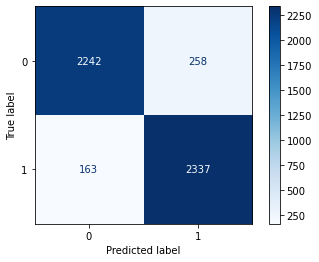

In [159]:
# Plot confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
# code --> https://github.com/mychetan/understanding_player_preference_using_reddit_data/blob/master/code/04_modeling.ipynb

In [194]:
tp_gs = 2337 # True Positives (Boosted Random Forest)
tn_gs = 2242 # True Negatives (Boosted Random Forest)
fp_gs = 258 # False Positives (Boosted Random Forest)
fn_gs = 163 # False Negatives (Boosted Random Forest)

In [195]:
# Calculate sensitivity.

sens_gs = tp_gs / (tp_gs + fn_gs)

print(f'Sensitivity: {round(sens_gs, 4)}')

Sensitivity: 0.9348


In [196]:
# Calculate specificity.

spec_gs = tn_gs / (tn_gs + fp_gs)

print(f'Specificity: {round(spec_gs, 4)}')

Specificity: 0.8968


In [197]:
# Calculate accuracy.

accuracy_gs = (tp_gs + tn_gs) / (tp_gs + tn_gs + fp_gs + fn_gs) 

print(f'Accuracy: {round(accuracy_gs, 4)}')

Accuracy: 0.9158


In [198]:
# Calculate precision.

precision_gs = tp_gs / (tp_gs + fp_gs)

print(f'Precision: {round(precision_gs, 4)}')

Precision: 0.9006


In [199]:
# Calculate recall.

recall_gs = tp_gs / (tp_gs + fn_gs)

print(f'Recall: {round(recall_gs, 4)}')

Recall: 0.9348


**Analysis:**
<br>
The boosted random forest model has a sensitivity of 89.7%, which is the best score of all three models. The specificity is 91.6%, which is about the same as the other models.

### Comparing the Models and Conclusion

Comparing Model Accuracy:
<br>
The boosed random forest model performed the best on accuracy, recall and sensitivity. Precision and sensitivity were not as good as the other models. While we would like the boosted random forest to outperform the other two models, the lower precision and sensitivity scores are not alarming. The decision tree and random forest were overfit to the training data. Neither one could be the winner of the three models since they would not generalize to new data. The boosted random forest is the clear favorite.

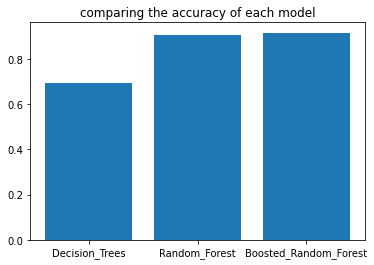

In [202]:
Accuracy = [accuracy_dt, accuracy_rf, accuracy_gs]
Methods = ['Decision_Trees', 'Random_Forest', 'Boosted_Random_Forest']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing the Accuracy of Each Model')
plt.show()

Comparing Model Precision

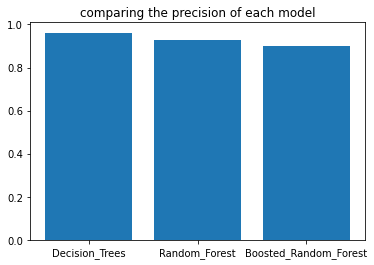

In [203]:
Precision = [precision_dt, precision_rf, precision_gs]
Precision_pos = np.arange(len(Methods))
plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods)
plt.title('Comparing the Precision of Each Model')
plt.show()

Comparing Model Recall

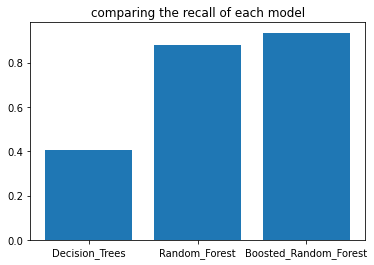

In [204]:
Recall = [recall_dt, recall_rf, recall_gs]
Recall_pos = np.arange(len(Methods))
plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods)
plt.title('Comparing the Recall of Each Model')
plt.show()

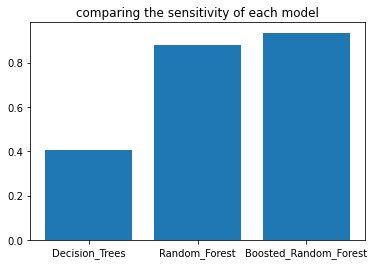

In [208]:
Sensitivity = [sens_dt, sens_rf, sens_gs]
Sensitivity_pos = np.arange(len(Methods))
plt.bar(Sensitivity_pos, Recall)
plt.xticks(Sensitivity_pos, Methods)
plt.title('Comparing the Sensitivity of Each Model')
plt.show()

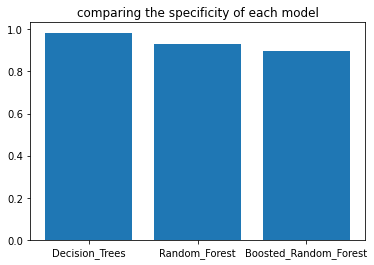

In [210]:
Specificity = [spec_dt, spec_rf, spec_gs]
Specificity_pos = np.arange(len(Methods))
plt.bar(Specificity_pos, Recall)
plt.xticks(Specificity_pos, Methods)
plt.title('Comparing the Specificity of Each Model')
plt.show()